# Graph Neural Network (GNN)

Prediction of the intention of pedestrians to cross the street or not, using Graph Neural Networks and the coordinates of their skeleton that was previously generated using Openpose in the JAAD dataset.

**Input:** Pedestrian skeleton graph.

**Output:** Binary classification (crossing or not crossing the street).

In [3]:
import numpy as np

from torch import from_numpy
from torch import cuda
from torch import no_grad
from torch import optim

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt

import pandas as pd

%matplotlib inline

from Code.GNN import *
from Code.SkeletonsDataset import *
from Code.ModelTrainEvaluate import *

# Dataset

In [4]:
train_dataset = SkeletonsDataset('Data/train_annotations_with_skeletons.csv')

print('train_dataset len:', len(train_dataset))
print('Shape of each skeletons data (x):', train_dataset.data[0].x.shape)

train_dataset.loadedData

train_dataset len: 44972
Shape of each skeletons data (x): torch.Size([25, 3])


,video,id,frame,occluded,outside,x2,y2,x1,y1,age,...,pose_front,pose_left,pose_right,stroller_cart,sunglasses,umbrella,speed,video_path,skeleton,skeleton_detected
0,video_0001,0_1_2b,0,0,0,1486.0,892.0,1398.0,654.0,adult,...,1.0,0.0,0.0,0.0,0.0,0.0,moving_slow,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1448.57, 674.503, 0.924437], [1442.74, 698.0...",True
1,video_0001,0_1_2b,1,0,0,1490.0,894.0,1402.0,655.0,adult,...,1.0,0.0,0.0,0.0,0.0,0.0,moving_slow,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1451.47, 674.493, 0.906491], [1445.66, 698.0...",True
2,video_0001,0_1_2b,2,0,0,1493.0,897.0,1406.0,656.0,adult,...,1.0,0.0,0.0,0.0,0.0,0.0,moving_slow,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1451.58, 674.604, 0.856983], [1448.49, 698.0...",True
3,video_0001,0_1_2b,3,0,0,1496.0,899.0,1409.0,657.0,adult,...,1.0,0.0,0.0,0.0,0.0,0.0,moving_slow,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1457.41, 677.444, 0.82119], [1448.66, 698.11...",True
4,video_0001,0_1_2b,4,0,0,1499.0,901.0,1413.0,658.0,adult,...,1.0,0.0,0.0,0.0,0.0,0.0,moving_slow,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1466.12, 677.516, 0.846119], [1451.56, 700.9...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44967,video_0278,0_278_2189b,115,0,0,1135.0,868.0,1029.0,642.0,adult,...,0.0,0.0,1.0,0.0,0.0,0.0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[0.0, 0.0, 0.0], [1074.76, 691.992, 0.916943]...",True
44968,video_0278,0_278_2189b,116,0,0,1151.0,874.0,1044.0,643.0,adult,...,0.0,0.0,1.0,0.0,0.0,0.0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[0.0, 0.0, 0.0], [1095.41, 692.256, 0.973779]...",True
44969,video_0278,0_278_2189b,117,0,0,1167.0,880.0,1058.0,643.0,adult,...,0.0,0.0,1.0,0.0,0.0,0.0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[0.0, 0.0, 0.0], [1115.94, 692.05, 0.955257],...",True
44970,video_0278,0_278_2189b,118,0,0,1183.0,886.0,1073.0,644.0,adult,...,0.0,0.0,1.0,0.0,0.0,0.0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1160.16, 671.633, 0.0615215], [1127.72, 694....",True


Important columns:

In [5]:
train_dataset.loadedData[['video','frame','decision_point','skeleton','skeleton_detected','crossing']]

,video,frame,decision_point,skeleton,skeleton_detected,crossing
0,video_0001,0,26,"[[1448.57, 674.503, 0.924437], [1442.74, 698.0...",True,-1
1,video_0001,1,26,"[[1451.47, 674.493, 0.906491], [1445.66, 698.0...",True,-1
2,video_0001,2,26,"[[1451.58, 674.604, 0.856983], [1448.49, 698.0...",True,-1
3,video_0001,3,26,"[[1457.41, 677.444, 0.82119], [1448.66, 698.11...",True,-1
4,video_0001,4,26,"[[1466.12, 677.516, 0.846119], [1451.56, 700.9...",True,-1
...,...,...,...,...,...,...
44967,video_0278,115,-1,"[[0.0, 0.0, 0.0], [1074.76, 691.992, 0.916943]...",True,1
44968,video_0278,116,-1,"[[0.0, 0.0, 0.0], [1095.41, 692.256, 0.973779]...",True,1
44969,video_0278,117,-1,"[[0.0, 0.0, 0.0], [1115.94, 692.05, 0.955257],...",True,1
44970,video_0278,118,-1,"[[1160.16, 671.633, 0.0615215], [1127.72, 694....",True,1


In [6]:
train_dataset.shuffle()
test_dataset = train_dataset[:5000]
train_dataset = train_dataset[5000:]

val_dataset = SkeletonsDataset('Data/val_annotations_with_skeletons.csv')
val_dataset.shuffle()

len(train_dataset), len(val_dataset), len(test_dataset)

(39972, 5272, 5000)

## Training

In [7]:
# First element of training subset:
t0 = train_dataset[0]

# Node features:
t1 = t0.x

# Number of nodes:
numberOfNodes = t1.shape[0]

# Number of dimensions of each node features:
embed_dim = t1.shape[1]

print('Number of nodes per skeleton:', numberOfNodes)
print('Number of features per node:', embed_dim)

Number of nodes per skeleton: 25
Number of features per node: 3


Epoch: 01, Loss: 10.5998, Train acc: 0.8783, Val acc: 0.7187
Epoch: 02, Loss: 9.9115, Train acc: 0.8791, Val acc: 0.7210
Epoch: 03, Loss: 9.6334, Train acc: 0.8846, Val acc: 0.7274
Epoch: 04, Loss: 9.4298, Train acc: 0.8844, Val acc: 0.7248
Epoch: 05, Loss: 9.2397, Train acc: 0.8821, Val acc: 0.7215
Epoch: 06, Loss: 9.1281, Train acc: 0.8809, Val acc: 0.7197
Epoch: 07, Loss: 9.0260, Train acc: 0.8901, Val acc: 0.7274
Epoch: 08, Loss: 8.9234, Train acc: 0.8859, Val acc: 0.7244
Epoch: 09, Loss: 8.8377, Train acc: 0.8882, Val acc: 0.7246
Epoch: 10, Loss: 8.7784, Train acc: 0.8898, Val acc: 0.7242


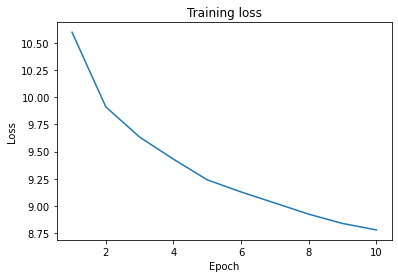

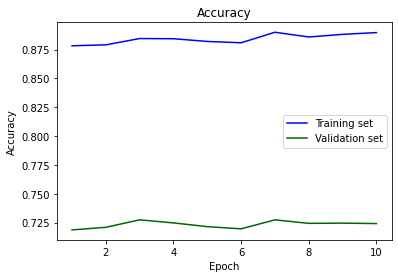

In [8]:
num_epochs = 10
batch_size = 30

device = torch.device('cpu')
model = GNN(embed_dim, 2, numberOfNodes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit = torch.nn.BCELoss()

train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

loss_values = []

acc_train = []
acc_val = []

for epoch in range(num_epochs):

    e_loss = train(model, train_loader, device, optimizer, crit)
    loss_values.append(e_loss)

    train_acc = evaluate(model, train_loader, device)
    val_acc = evaluate(model, val_loader, device)

    acc_train.append(train_acc)
    acc_val.append(val_acc)
    
    if num_epochs < 20:
        print('Epoch: {:02d}, Loss: {:.4f}, Train acc: {:.4f}, Val acc: {:.4f}'.format(epoch + 1, e_loss, train_acc, val_acc))



plt.figure()
plt.title("Training loss")
plt.plot(np.arange(1, num_epochs+1), loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


plt.figure()
plt.title("Accuracy")
plt.plot(np.arange(1, num_epochs+1), acc_train, color='blue', label='Training set')
plt.plot(np.arange(1, num_epochs+1), acc_val, color='darkgreen', label='Validation set')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Testing

In [9]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)
test_acc = evaluate(model, test_loader, device)

print('Test accuracy: {:.4f}'.format(test_acc, 4))

Test accuracy: 0.8948
